In [1]:
# Imports

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mutual_info_score
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

plt.style.use('classic')

In [2]:
# Mount Google Drive and Set Paths

drive.mount('/content/drive')
base_path = '/content/drive/My Drive/Masters/Master\'s Spring 2025/CSE 572/Project/Data_HC/'

# CSV files
csv_files = {
    "inmates": "inmates.csv",
    "appeals": "appeals.csv",
    "classifications": "classifications.csv",
    "detainers": "detainers.csv",
    "infractions": "infractions.csv",
    "parole_actions": "parole_actions.csv",
    "sentences": "sentences.csv",
    "work_programs": "work_programs.csv"
}

# Photos path
photos_path = os.path.join(base_path, 'photos')

Mounted at /content/drive


In [3]:
# Load All DataFrames

dfs = {}
for name, file in csv_files.items():
    path = os.path.join(base_path, file)
    dfs[name] = pd.read_csv(path)

for k, df in dfs.items():
    print(f"{k}: {df.shape}")

inmates: (966, 19)
appeals: (487, 4)
classifications: (12210, 5)
detainers: (1453, 6)
infractions: (4438, 5)
parole_actions: (500, 4)
sentences: (4272, 9)
work_programs: (5042, 4)


In [4]:
# Count Male and Female Inmates

# Clean gender labels
inmates = dfs['inmates'].copy()
inmates['gender'] = inmates['gender'].str.strip().str.title()

# Count by gender
gender_counts = inmates['gender'].value_counts()

# Print results
num_men = gender_counts.get('Male', 0)
num_women = gender_counts.get('Female', 0)

print(f"Total Male Inmates: {num_men}")
print(f"Total Female Inmates: {num_women}")

Total Male Inmates: 483
Total Female Inmates: 483


In [5]:
# Bias Metrics (helper functions)

import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.metrics import mutual_info_score

def shannon_entropy(series):
    p = series.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p + 1e-9))
    return entropy

def shannon_evenness(series):
    entropy = shannon_entropy(series)
    S = series.nunique()
    if S <= 1:
        return 0
    return entropy / np.log2(S)

def effective_species(series):
    entropy = shannon_entropy(series)
    return np.exp(entropy)

def berger_parker_index(series):
    p = series.value_counts(normalize=True)
    return p.max()

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [6]:
# Prepare Metadata Features from inmates.csv

# Copy core inmate info
inmates = dfs['inmates'].copy()

# Drop rows missing info
inmates = inmates.dropna(subset=['gender', 'ethnic_origin', 'photo_filename'])

# Convert height to inches
def height_to_inches(height_str):
    try:
        feet, inches = height_str.lower().split("f")
        return int(feet.strip()) * 12 + int(inches.strip())
    except:
        return np.nan

inmates['height_in'] = inmates['height'].apply(height_to_inches)

# Clean up race and gender
inmates['race'] = inmates['ethnic_origin'].str.strip().str.title()
inmates['gender'] = inmates['gender'].str.strip().str.title()

# Age
# Bin based on realistic assumption of age distribution
inmates['age_group'] = pd.qcut(inmates['weight'], q=4, labels=['Young', 'Middle-Age', 'Older', 'Senior'])

# Create a master demographic table
demographics = inmates[['inmate_id', 'gender', 'race', 'age_group', 'custody_class', 'photo_filename']].copy()

# Preview the cleaned demographic set
print("Cleaned demographic head:")
print(demographics.head())

Cleaned demographic head:
   inmate_id  gender       race   age_group     custody_class photo_filename
0     299789  Female      Black  Middle-Age        Close/High     299789.jpg
1     364642  Female  Caucasian      Senior  Minimum/Moderate     364642.jpg
3     371132  Female  Caucasian      Senior    Minimum/Lowest     371132.jpg
4     171728  Female  Caucasian      Senior     Medium/Lowest     171728.jpg
5     297321  Female  Caucasian      Senior       Minimum/Low     297321.jpg


In [7]:
# Compute Representational Bias Metrics

def compute_bias_summary(df, column_name):
    entropy = shannon_entropy(df[column_name])
    evenness = shannon_evenness(df[column_name])
    ens = effective_species(df[column_name])
    bp_index = berger_parker_index(df[column_name])

    return {
        "Column": column_name,
        "Shannon Entropy": entropy,
        "Shannon Evenness": evenness,
        "ENS": ens,
        "Berger-Parker Index": bp_index
    }

cols_to_check = ['race', 'gender', 'age_group']
bias_results = [compute_bias_summary(demographics, col) for col in cols_to_check]
bias_df = pd.DataFrame(bias_results)

display(bias_df)

,Column,Shannon Entropy,Shannon Evenness,ENS,Berger-Parker Index
0,race,2.068482,0.736808,7.912801,0.340249
1,gender,0.999997,0.999997,2.718273,0.501037
2,age_group,1.998209,0.999104,7.375834,0.264033


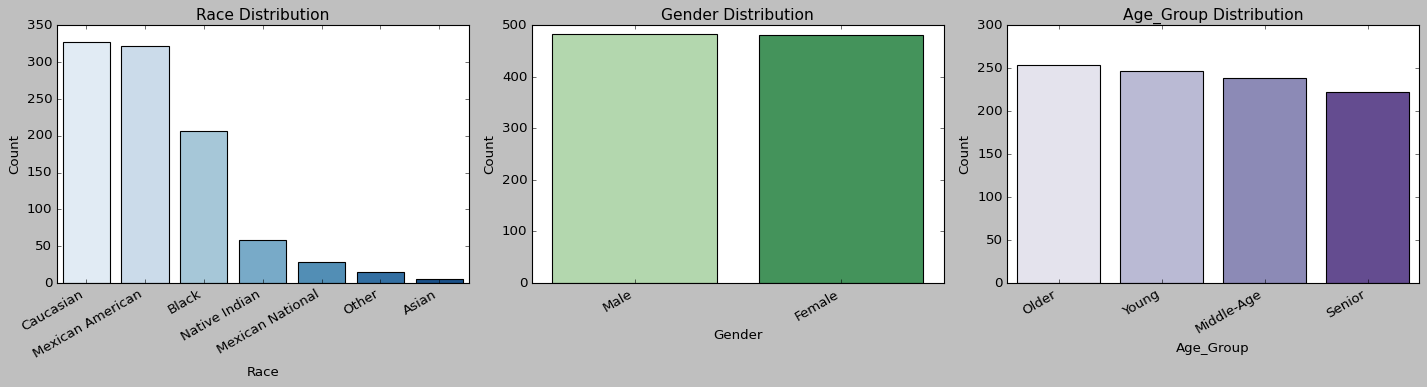

In [8]:
#  Bar Plots for Demographic Distributions

# Updated Code Block 6a: Enhanced Bar Plots

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# Different palettes for each subplot
palette_list = ['Blues', 'Greens', 'Purples']

for ax, col, palette in zip(axs, cols_to_check, palette_list):
    order = demographics[col].value_counts().index
    sns.countplot(x=col, data=demographics, ax=ax, order=order, palette=sns.color_palette(palette, len(order)))

    ax.set_title(f"{col.title()} Distribution", fontsize=14)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_xlabel(col.title(), fontsize=12)

    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

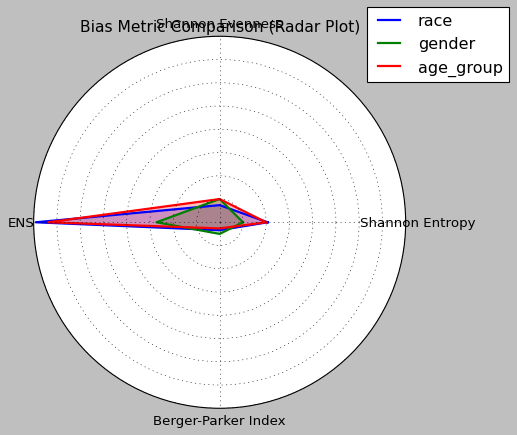

In [9]:
# Radar Plot for Bias Metrics

import matplotlib.pyplot as plt
from math import pi

def plot_radar(bias_df):
    categories = list(bias_df["Column"])
    metrics = ['Shannon Entropy', 'Shannon Evenness', 'ENS', 'Berger-Parker Index']

    # Radar setup
    N = len(metrics)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    for _, row in bias_df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=row['Column'])
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticklabels([])
    ax.set_title("Bias Metric Comparison (Radar Plot)", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.show()

plot_radar(bias_df)

In [10]:
# Cramér’s V for Stereotypical Bias

# Join offense type into demographic table
offense_df = dfs['sentences'][['inmate_id', 'crime']].copy()
offense_df = offense_df.dropna().drop_duplicates('inmate_id')

# Merge for stereotype correlation test
merged = demographics.merge(offense_df, on='inmate_id')

In [11]:
# Formatting Cramér’s V for Stereotypical Bias Ouput

def cramers_v_summary(df, target_col):
    summary = []

    for col in ['race', 'gender', 'age_group']:
        v = cramers_v(df[col], df[target_col])

        # Ideal V is close to 0 (no association)
        ideal_v = 0.1

        if v <= 0.1:
            flag = '✅'
        elif v <= 0.2:
            flag = '⚠️'
        else:
            flag = '❌'

        summary.append({
            "Attribute": col,
            "Target": target_col,
            "Cramér’s V": round(v, 4),
            "Ideal V (≤0.1)": ideal_v,
            "Bias Flag": flag
        })

    return pd.DataFrame(summary)


# Apply to merged demographics-crime dataset
cramersv_df = cramers_v_summary(merged, 'crime')

# Display table
from IPython.display import display
display(cramersv_df)

,Attribute,Target,Cramér’s V,Ideal V (≤0.1),Bias Flag
0,race,crime,0.1980,0.1,⚠️
1,gender,crime,0.3373,0.1,❌
2,age_group,crime,0.0520,0.1,✅


In [12]:
# Enhanced Bias Summary with Targets & Flags

def compute_bias_with_targets(df, column_name):
    series = df[column_name]
    num_classes = series.nunique()

    actual_entropy = shannon_entropy(series)
    max_entropy = np.log2(num_classes) if num_classes > 1 else 0
    evenness = actual_entropy / max_entropy if max_entropy > 0 else 0
    ens = np.exp(actual_entropy)
    bp = berger_parker_index(series)

    # Ideal values
    ideal_ens = num_classes
    ideal_bp = 1 / num_classes if num_classes > 0 else 1

    # Flags
    entropy_flag = '✅' if evenness >= 0.75 else '⚠️'
    ens_flag = '✅' if ens >= 0.75 * ideal_ens else '⚠️'
    bp_flag = '✅' if bp <= 1.5 * ideal_bp else '⚠️'

    return {
        "Attribute": column_name,
        "Num Classes": num_classes,
        "Entropy": round(actual_entropy, 3),
        "Max Entropy": round(max_entropy, 3),
        "Evenness (SEI)": round(evenness, 3),
        "ENS": round(ens, 2),
        "Ideal ENS": round(ideal_ens, 2),
        "BP Index": round(bp, 3),
        "Ideal BP": round(ideal_bp, 3),
        "Entropy Flag": entropy_flag,
        "ENS Flag": ens_flag,
        "BP Flag": bp_flag
    }

# Apply to your key demographics
cols_to_check = ['race', 'gender', 'age_group']
bias_diagnostics = [compute_bias_with_targets(demographics, col) for col in cols_to_check]
bias_diag_df = pd.DataFrame(bias_diagnostics)

# Display
from IPython.display import display
display(bias_diag_df)

,Attribute,Num Classes,Entropy,Max Entropy,Evenness (SEI),ENS,Ideal ENS,BP Index,Ideal BP,Entropy Flag,ENS Flag,BP Flag
0,race,7,2.068,2.807,0.737,7.91,7,0.340,0.143,⚠️,✅,⚠️
1,gender,2,1.000,1.000,1.000,2.72,2,0.501,0.500,✅,✅,✅
2,age_group,4,1.998,2.000,0.999,7.38,4,0.264,0.250,✅,✅,✅


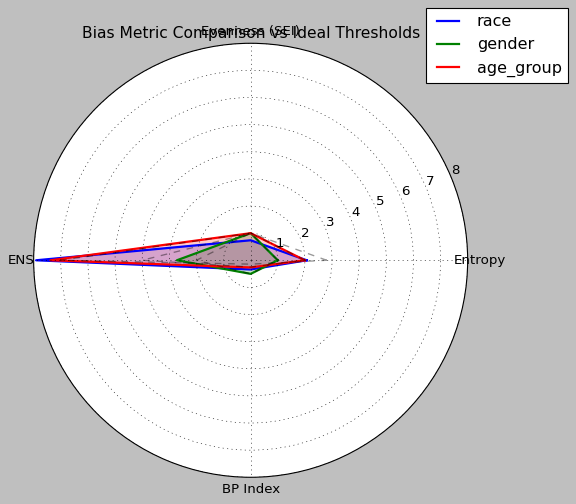

In [13]:
# Enhanced Radar Plot with Threshold Lines

def plot_radar_with_thresholds(bias_df):
    metrics = ['Entropy', 'Evenness (SEI)', 'ENS', 'BP Index']
    categories = bias_df['Attribute'].tolist()

    N = len(metrics)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)

    # Plot each attribute's metrics
    for i, row in bias_df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=row['Attribute'])
        ax.fill(angles, values, alpha=0.2)

    # Plot ideal thresholds
    ideal_values = [
        [row['Max Entropy'] for _, row in bias_df.iterrows()],
        [1.0] * len(bias_df),
        [row['Ideal ENS'] for _, row in bias_df.iterrows()],
        [row['Ideal BP'] for _, row in bias_df.iterrows()]
    ]

    for i in range(len(categories)):
        ideal = [ideal_values[j][i] for j in range(N)]
        ideal += ideal[:1]
        ax.plot(angles, ideal, linestyle='dashed', linewidth=1.2, color='black', alpha=0.4)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_title("Bias Metric Comparison vs Ideal Thresholds", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))
    plt.show()

plot_radar_with_thresholds(bias_diag_df)

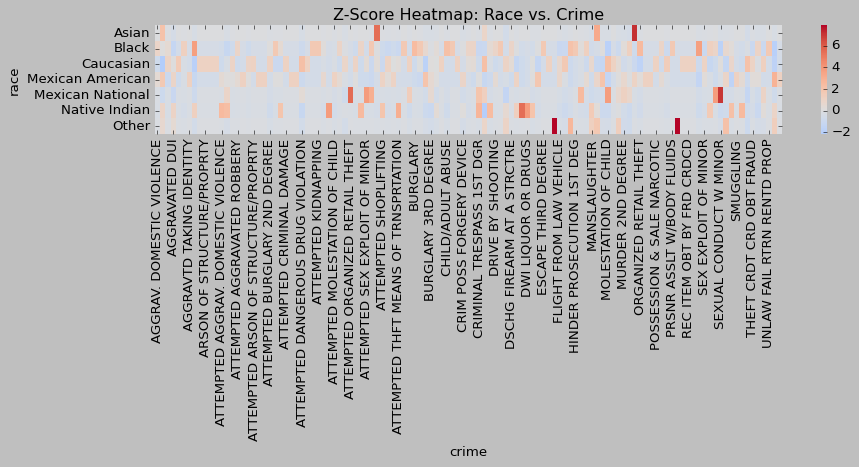

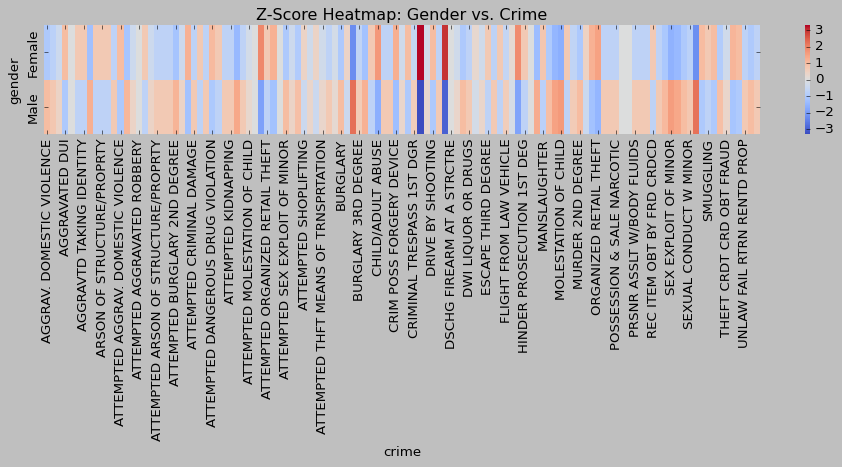

In [14]:
# Local Bias Heatmap using Z-Scores

def z_score_heatmap(df, row_col, col_col, title):
    contingency = pd.crosstab(df[row_col], df[col_col])
    expected = np.outer(contingency.sum(axis=1), contingency.sum(axis=0)) / contingency.values.sum()

    z_matrix = (contingency - expected) / np.sqrt(expected + 1e-6)
    z_df = pd.DataFrame(z_matrix, index=contingency.index, columns=contingency.columns)

    plt.figure(figsize=(12, 6))
    sns.heatmap(z_df, cmap='coolwarm', center=0, annot=False)
    plt.title(f"Z-Score Heatmap: {title}")
    plt.xlabel(col_col)
    plt.ylabel(row_col)
    plt.tight_layout()
    plt.show()

# Prepare merged data
offense_df = dfs['sentences'][['inmate_id', 'crime']].dropna().drop_duplicates('inmate_id')
merged = demographics.merge(offense_df, on='inmate_id')

# Race vs Crime
z_score_heatmap(merged, 'race', 'crime', 'Race vs. Crime')

# Gender vs Crime
z_score_heatmap(merged, 'gender', 'crime', 'Gender vs. Crime')

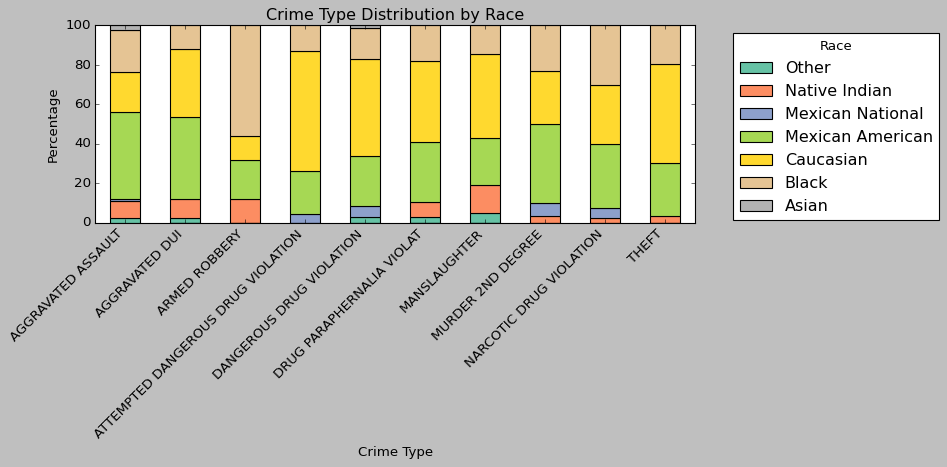

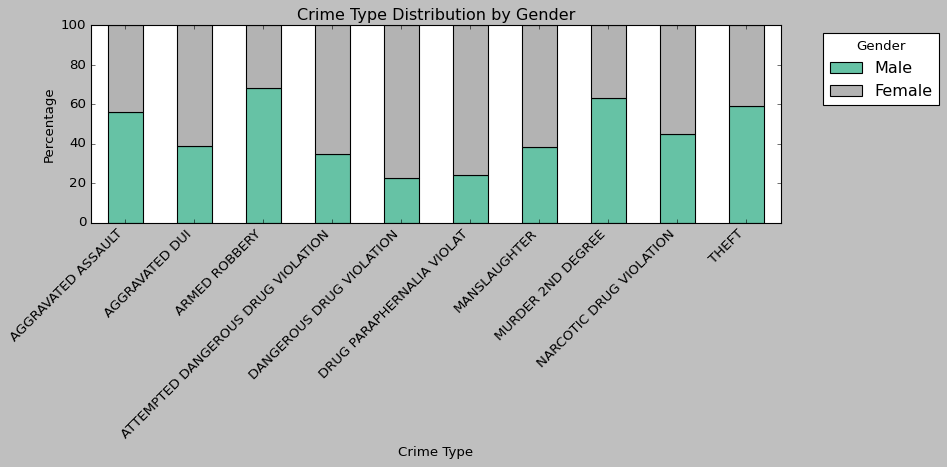

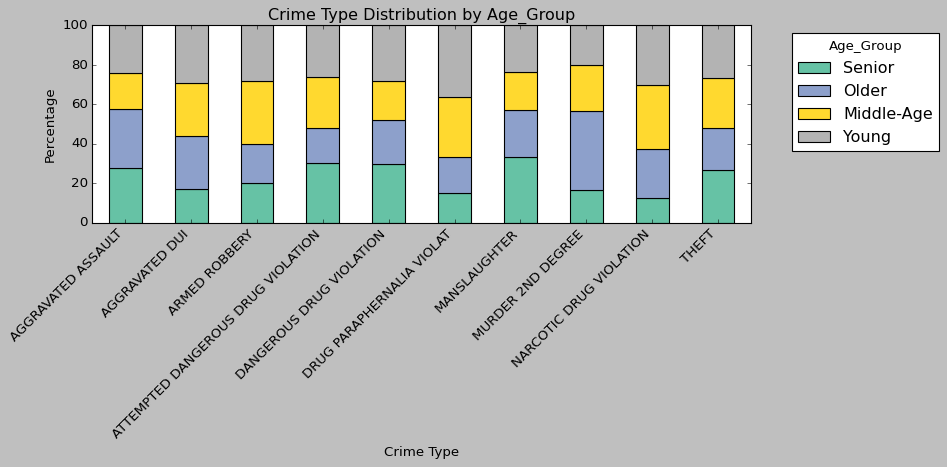

In [15]:
# Stacked Histograms of Crime by Demographic

def plot_crime_distribution_by_demo(merged_df, demo_col, top_n_crimes=10):
    # Limit to top N most frequent crimes to reduce clutter
    top_crimes = merged_df['crime'].value_counts().nlargest(top_n_crimes).index
    filtered_df = merged_df[merged_df['crime'].isin(top_crimes)]

    # Create a crosstab for stacked bar plot
    ctab = pd.crosstab(filtered_df['crime'], filtered_df[demo_col], normalize='index') * 100
    ctab = ctab[ctab.columns[::-1]]  # reverse order for cleaner plot

    # Plot
    ctab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
    plt.title(f"Crime Type Distribution by {demo_col.title()}")
    plt.ylabel("Percentage")
    plt.xlabel("Crime Type")
    plt.legend(title=demo_col.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Merge sentence (crime) with demographics (already done in Code Block 7)
# Race, gender, age_group
for demo in ['race', 'gender', 'age_group']:
    plot_crime_distribution_by_demo(merged, demo)